# 불균형데이터의 예측 성능

## 사례 1. ROC, PR 곡선 (불균형자료)

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
get_ipython().run_line_magic('matplotlib', 'inline')
#plt.rcParams['font.family']='Malgun Gothic' # 한글폰트

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.pipeline import Pipeline, make_pipeline
import scikitplot as skplt
from joblib import dump, load

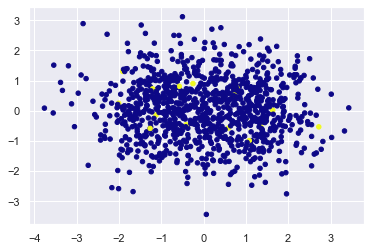

In [5]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01],
                          random_state=1)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='plasma')

In [172]:
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)

In [173]:
# summarize dataset
print('Dataset: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Train: Class0=%d, Class1=%d' % (len(trainy[trainy==0]), len(trainy[trainy==1])))
print('Test: Class0=%d, Class1=%d' % (len(testy[testy==0]), len(testy[testy==1])))

Dataset: Class0=985, Class1=15
Train: Class0=492, Class1=8
Test: Class0=493, Class1=7


In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as pyplot

In [175]:
# plot no skill and model roc curves
def plot_roc_curve(test_y, naive_probs, model_probs):
    # plot naive skill roc curve
    fpr, tpr, _ = roc_curve(test_y, naive_probs)
    pyplot.plot(fpr, tpr, linestyle='--', label='No Skill')
    # plot model roc curve
    fpr, tpr, _ = roc_curve(test_y, model_probs)
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate');     pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

DummyClassifier(strategy='stratified')

No Skill ROC AUC 0.491


LogisticRegression()

Logistic ROC AUC 0.869


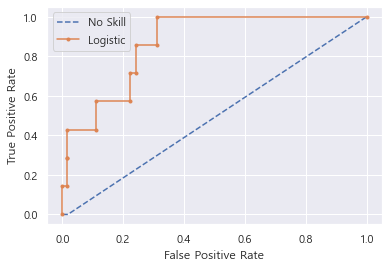

In [176]:
model = DummyClassifier(strategy='stratified')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
naive_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, naive_probs)
print('No Skill ROC AUC %.3f' % roc_auc)
# skilled model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate roc auc
roc_auc = roc_auc_score(testy, model_probs)
print('Logistic ROC AUC %.3f' % roc_auc)
# plot roc curves
plot_roc_curve(testy, naive_probs, model_probs)

In [177]:
# plot no skill and model precision-recall curves
def plot_pr_curve(test_y, model_probs):
    # calculate the no skill line as the proportion of the positive class
    no_skill = len(test_y[test_y==1]) / len(test_y)
    # plot the no skill precision-recall curve
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('Recall'); pyplot.ylabel('Precision')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

No Skill PR AUC: 0.007


LogisticRegression()

Logistic PR AUC: 0.228


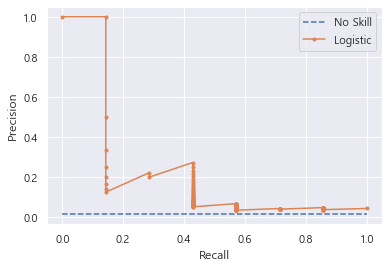

In [178]:
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, naive_probs)
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, model_probs)
auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)
# plot precision-recall curves
plot_pr_curve(testy, model_probs)

To explain why the ROC and PR curves tell a different story, recall that the PR curve
focuses on the minority class, whereas the ROC curve covers both classes. If we use a threshold
of 0.5 and use the logistic regression model to make a prediction for all examples in the test
set, we see that it predicts class 0 or the majority class in all cases. This can be confirmed by
using the fit model to predict crisp class labels that will use the default threshold of 0.5. The
distribution of predicted class labels can then be summarized.

In [179]:
from collections import Counter
# predict class labels
yhat = model.predict(testX)
# summarize the distribution of class labels
print(Counter(yhat))

Counter({0: 500})


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

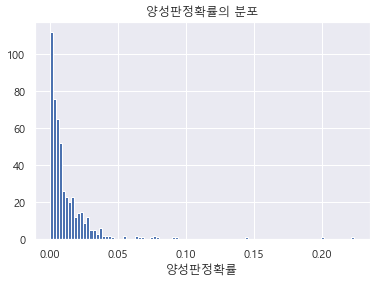

In [194]:
yhat = model.predict_proba(testX)
model_probs = yhat[:, 1]
pd.DataFrame(model_probs).hist(bins=100)
pyplot.title('양성판정확률의 분포')
pyplot.xlabel('양성판정확률')

In [198]:
data = pd.DataFrame(yhat[:, 1], columns=['y_predict'])

## How to Calibrate Probabilities

In [199]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(base_estimator=model, cv=3)
calibrated_clf.fit(trainX, trainy)

CalibratedClassifierCV(base_estimator=LogisticRegression(), cv=3)

In [200]:
calibrated_clf.predict_proba(testX)[:5, :]

array([[0.98236164, 0.01763836],
       [0.98263936, 0.01736064],
       [0.98207952, 0.01792048],
       [0.98266856, 0.01733144],
       [0.97901248, 0.02098752]])

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

Text(0.5, 1.0, '양성판정확률의 분포')

Text(0.5, 0, '양성판정확률')

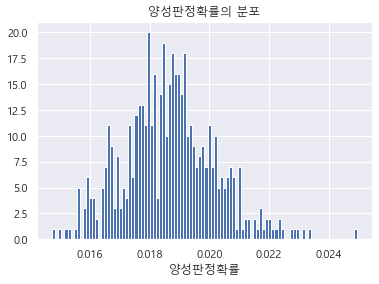

In [201]:
yhat = calibrated_clf.predict_proba(testX)
model_probs = yhat[:, 1]
pd.DataFrame(model_probs).hist(bins=100)
pyplot.title('양성판정확률의 분포')
pyplot.xlabel('양성판정확률')

array([[<AxesSubplot:title={'center':'y_predict'}>,
        <AxesSubplot:title={'center':'y_predict_calibrated'}>]],
      dtype=object)

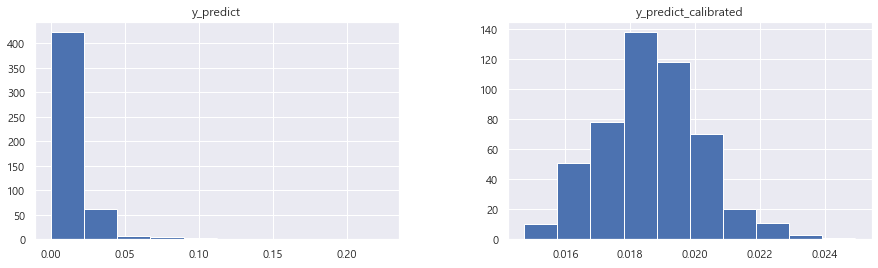

In [211]:
data['y_predict_calibrated'] = yhat[:, 1]
data.hist(figsize=(15,4))

In [215]:
data.head()

,y_predict,y_predict_calibrated
0,0.042028,0.017638
1,0.001389,0.017361
2,0.006842,0.017920
3,0.028677,0.017331
4,0.000467,0.020988


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='index', ylabel='y_predict'>

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='index', ylabel='y_predict_calibrated'>

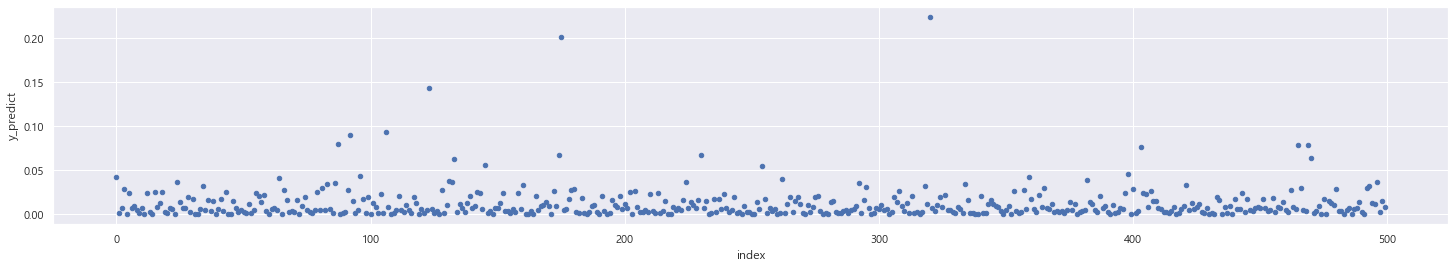

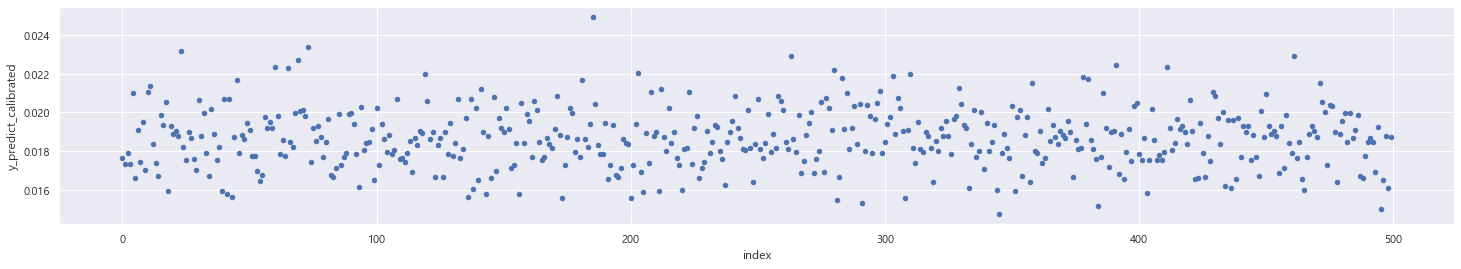

In [223]:
import warnings
warnings.filterwarnings(action='ignore') 
data.reset_index().plot.scatter(x='index', y = 'y_predict', figsize=(25,4))
data.reset_index().plot.scatter(x='index', y = 'y_predict_calibrated', figsize=(25,4))

https://scikit-learn.org/stable/modules/calibration.html#calibration

In [207]:
# data.to_excel('../working/data1.xlsx') # 실제는 data.xlsx

A histogram plot of the predicted probabilities for class 1 is also created, showing the center of mass (most predicted probabilities) is less than 0.5 and in fact is generally close to zero.

## 사례 2. PR > ROC (불균형자료)

In [94]:
from sklearn.svm import SVC
model = SVC(kernel='rbf')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 1024)
y_predict = model.fit(X_train, y_train).predict(X_test)
y_scores = model.fit(X_train, y_train).decision_function(X_test)

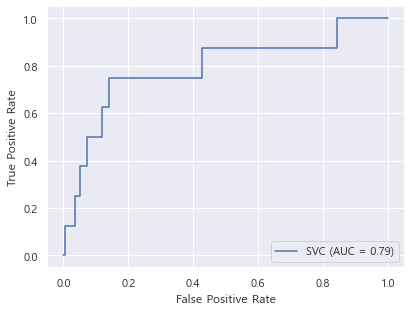

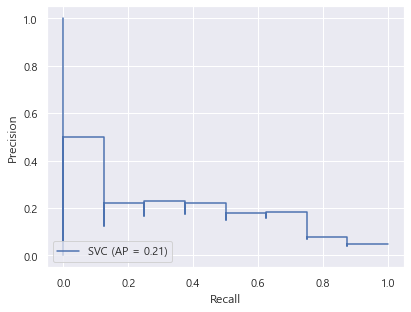

In [95]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
svc_disp = plot_roc_curve(model, X_test, y_test); plt.show()
svc_disp = plot_precision_recall_curve(model, X_test, y_test)

In [96]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       192
           1       0.00      0.00      0.00         8

    accuracy                           0.96       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.92      0.96      0.94       200



In [93]:
from IPython.display import Image
width=800; height=500

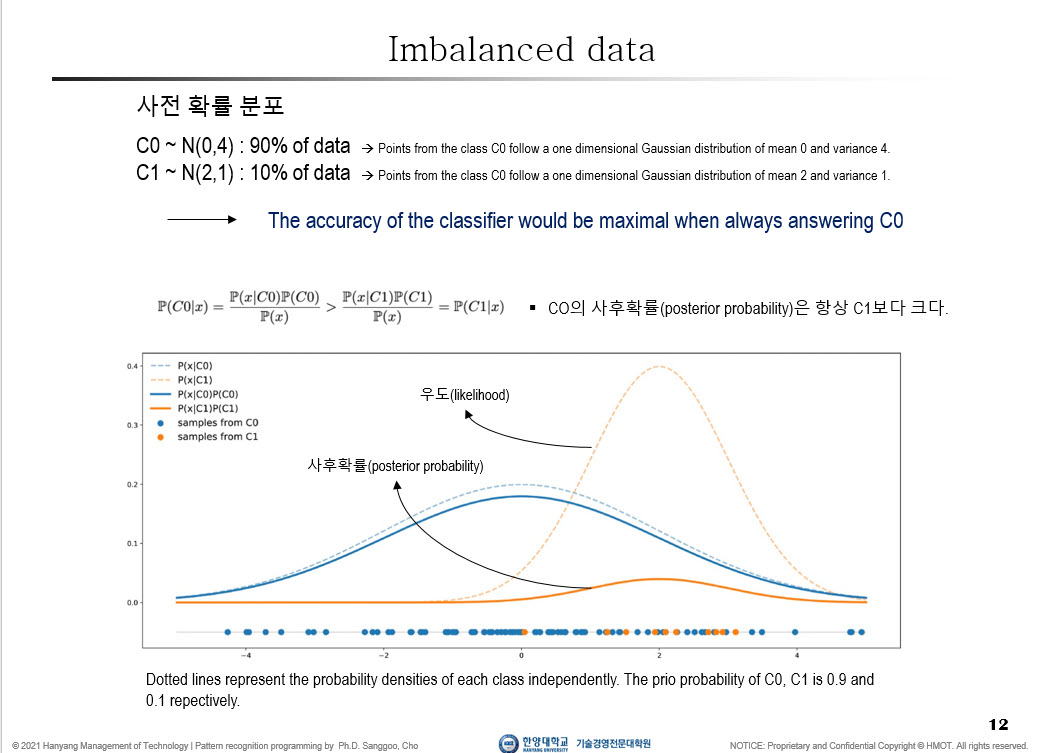

In [5]:
Image(filename='../image/imbalance/im_01.jpg', width=width, height=height)

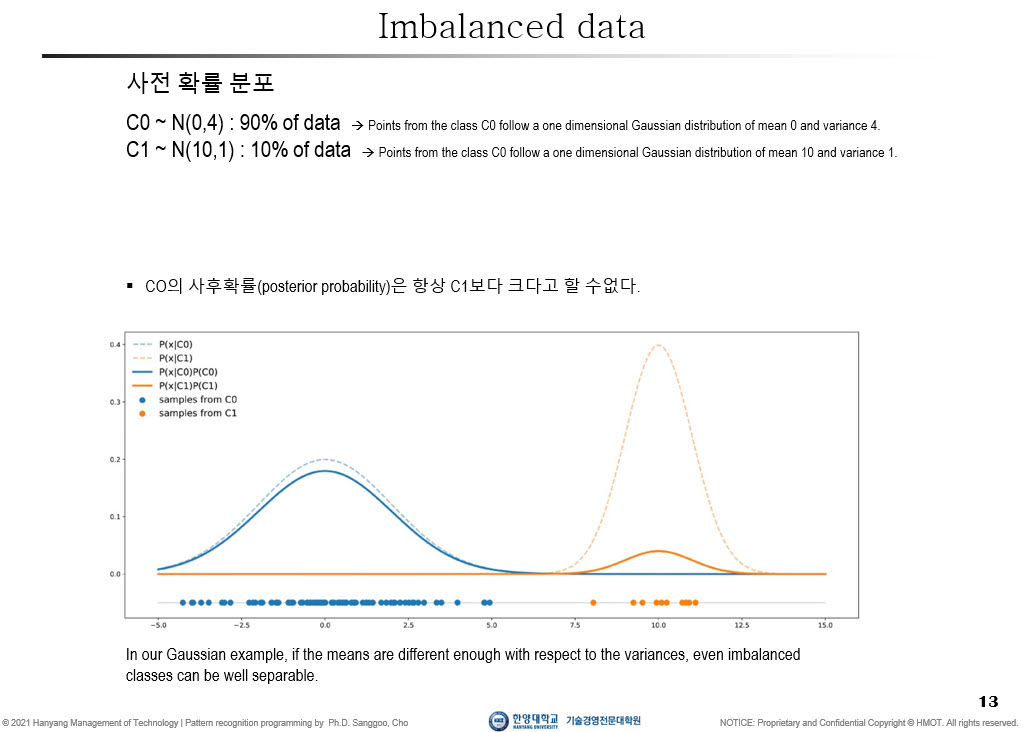

In [6]:
Image(filename='../image/imbalance/im_02.jpg', width=width, height=height)

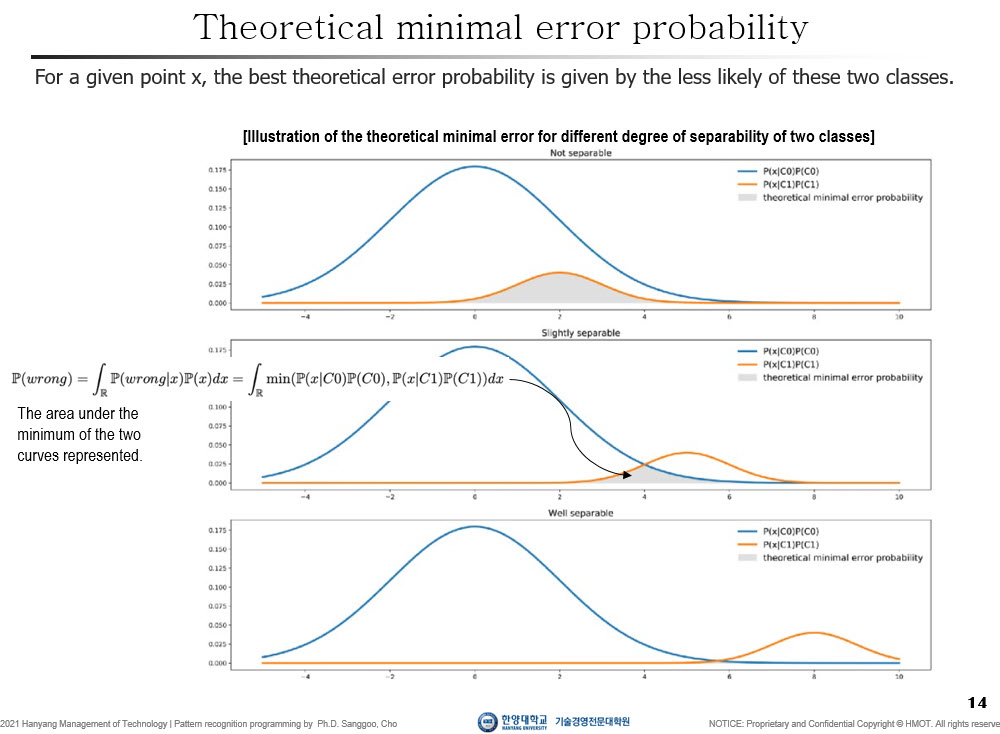

In [4]:
Image(filename='../image/imbalance/regrets.jpg', width=width, height=height)

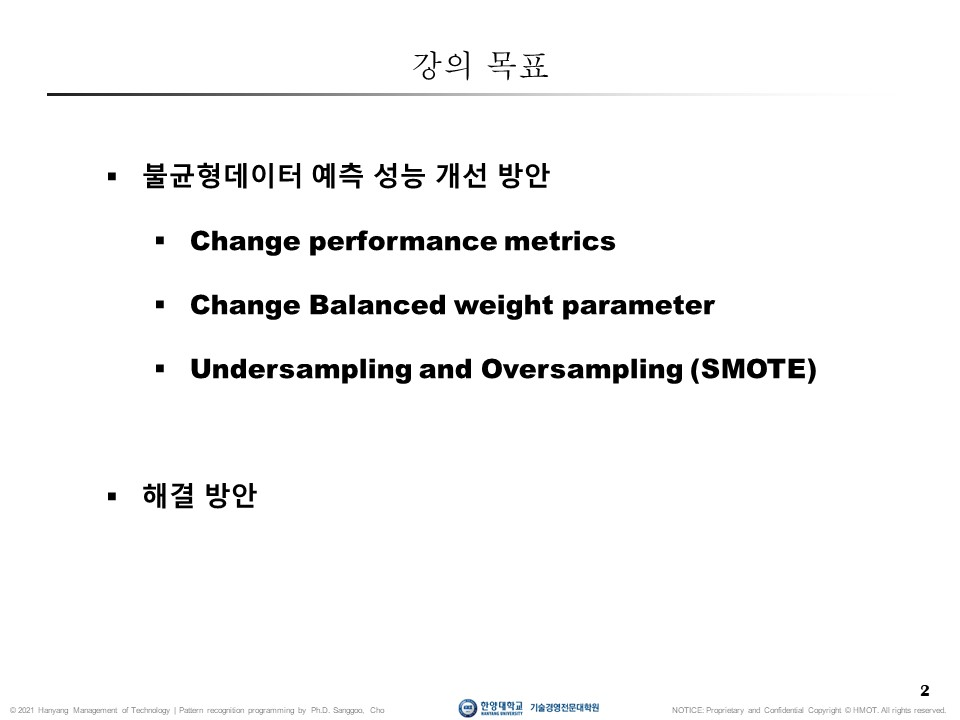

In [26]:
Image(filename='../image/imbalance/슬라이드2.jpg', width=width, height=height)

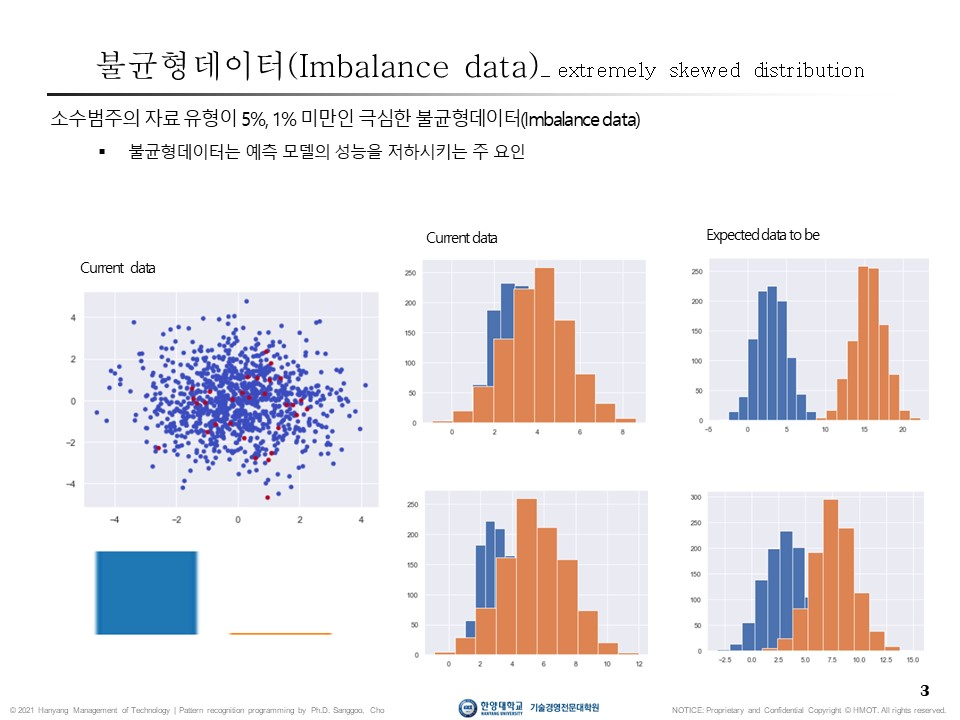

In [36]:
Image(filename='../image/imbalance/슬라이드3.jpg', width=width, height=height)

## 데이터 불러오기

### kaggle('../data/creditcard.csv'')로 search

In [37]:
df = pd.read_csv("../data/creditcard.csv")
df.head()
df.shape


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


(284807, 31)

## 데이터 전처리

In [12]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.iloc[:,:-1] = scaler.fit_transform(df.iloc[:,:-1])
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.996583,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,-1.996583,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-1.996562,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-1.996562,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-1.996541,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [14]:
df= df.sample(frac=0.1)

In [19]:
X = df.drop(['Class', 'Amount'], axis=1).iloc[:, 4:7]
y = df['Class']

In [20]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, 
                                                  stratify= y, random_state=11)

In [21]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression(random_state=11)
y_predict = lgr.fit(X_train, y_train).predict(X_test)
accuracy_score(y_test, y_predict)

0.9987712831314727

In [22]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5687
           1       1.00      0.30      0.46        10

    accuracy                           1.00      5697
   macro avg       1.00      0.65      0.73      5697
weighted avg       1.00      1.00      1.00      5697



## 1. 손실함수 조정(Sklearn utils)

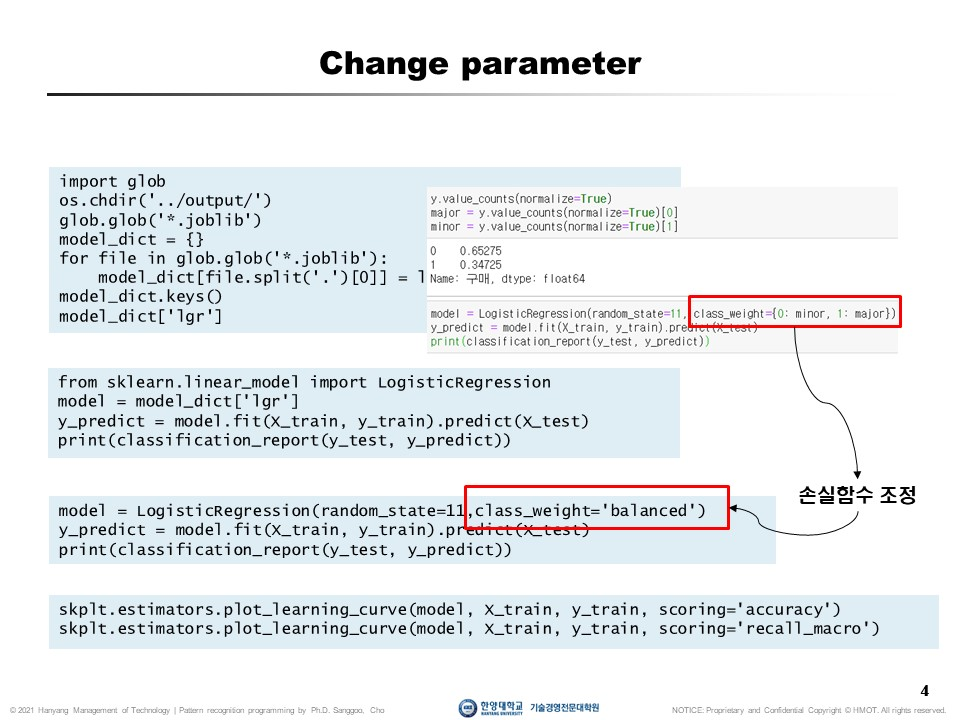

In [38]:
Image(filename='../image/imbalance/슬라이드4.jpg', width=width, height=height)

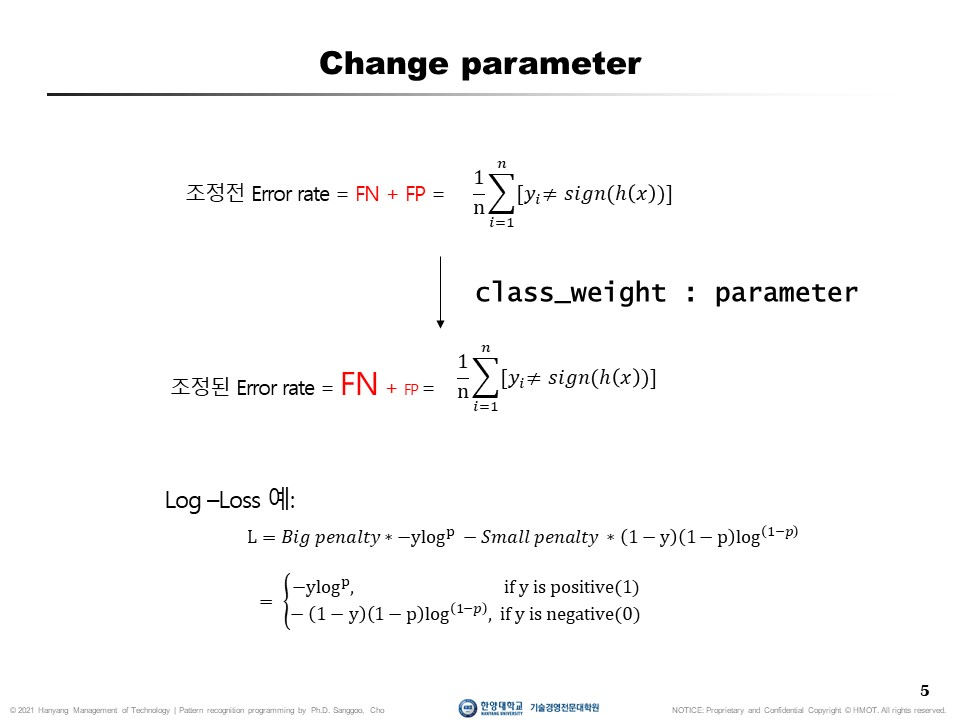

In [41]:
Image(filename='../image/imbalance/슬라이드5.jpg', width=width, height=height)

In [27]:
model = LogisticRegression(random_state=11, class_weight='balanced')
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5687
           1       0.02      0.80      0.04        10

    accuracy                           0.94      5697
   macro avg       0.51      0.87      0.51      5697
weighted avg       1.00      0.94      0.97      5697



In [28]:
y.value_counts(normalize=True)
negative = y.value_counts(normalize=True)[0]
positive = y.value_counts(normalize=True)[1]

0    0.998209
1    0.001791
Name: Class, dtype: float64

In [30]:
model = LogisticRegression(random_state=11, class_weight={0: positive, 1: negative})
y_predict = model.fit(X_train, y_train).predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5687
           1       0.02      0.80      0.04        10

    accuracy                           0.94      5697
   macro avg       0.51      0.87      0.51      5697
weighted avg       1.00      0.94      0.97      5697



## 1. Sklearn utils
### 손실함수 조정이 가능한 알고리즘

In [31]:
# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier)
# metrics
from sklearn.metrics import roc_curve, precision_recall_curve, auc, precision_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, average_precision_score
from sklearn.metrics import f1_score, recall_score, log_loss, brier_score_loss, matthews_corrcoef
from scipy.stats import ks_2samp

In [32]:
classifiers = {}
classifiers.update({'LGR': LogisticRegression(class_weight='balanced')})
classifiers.update({'SVC': SVC(class_weight='balanced', max_iter= 100, probability=True)})
classifiers.update({'Decisiontree': DecisionTreeClassifier(class_weight='balanced')})
classifiers.update({'Extratree': ExtraTreesClassifier(class_weight='balanced', n_estimators=250)})
classifiers.update({'Random Forest': RandomForestClassifier(class_weight='balanced', n_estimators=100)})

In [33]:
from tqdm import tqdm_notebook
kf = KFold(n_splits=2)
results = {}

for classifier_label, classifier in tqdm_notebook(classifiers.items()):
    steps = [('classifier', classifier)]
    pipeline = Pipeline(steps = steps)
    param_grid = {}
    
    gs = RandomizedSearchCV(pipeline, param_grid, cv = kf,
                          n_iter = 2,
                          scoring = 'f1_macro')  
    y_pred = gs.fit(X_train, y_train).predict(X_test)
    y_proba = gs.predict_proba(X_test)
    y_score = y_proba[:,1]
    
    result = {'Best Parameters': gs.best_params_,
              'AUROC': roc_auc_score(y_test, y_score),
              'Average PR': average_precision_score(y_test, y_score),
              'F1-score': f1_score(y_test, y_pred),
              'Log_loss': log_loss(y_test, y_proba),
              'Brier_score': brier_score_loss(y_test, y_score),
             }
 
    results.update({classifier_label: result})

In [34]:
pd.DataFrame(results).T.drop(['Best Parameters'], axis=1).sort_values('Log_loss')

,AUROC,Average PR,F1-score,Log_loss,Brier_score
Extratree,0.895261,0.661376,0.571429,0.014629,0.00091
Random Forest,0.845938,0.700527,0.461538,0.019911,0.000928
SVC,0.244452,0.00122,0.003504,0.026531,0.001757
Decisiontree,0.799472,0.300702,0.545455,0.060626,0.001755
LGR,0.904589,0.593354,0.042895,0.243736,0.0647


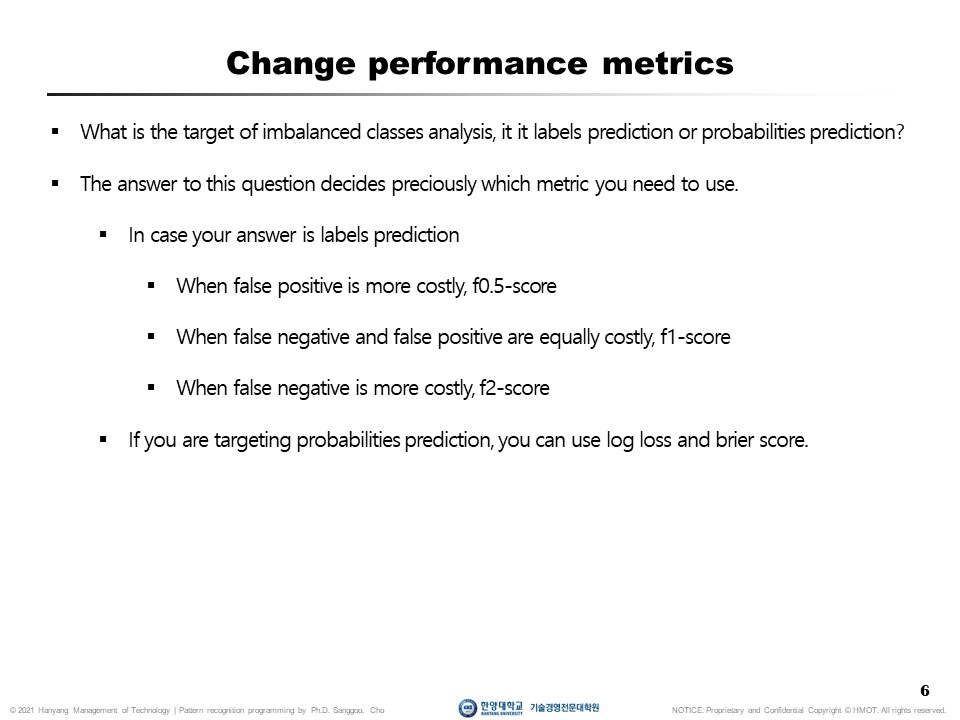

In [40]:
Image(filename='../image/imbalance/슬라이드6.jpg', width=width, height=height)

# 2 SMOTE
- 가우시안 나이브 등과 같은 알고리즘은 Class weight 파라미터가 없음

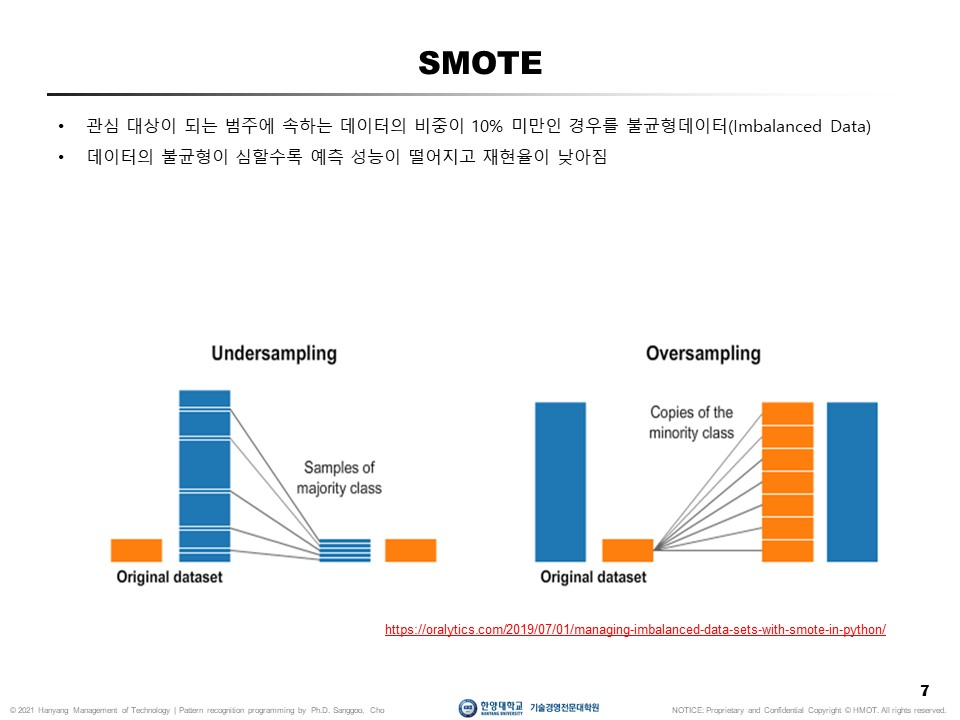

In [42]:
Image(filename='../image/imbalance/슬라이드7.jpg', width=width, height=height)

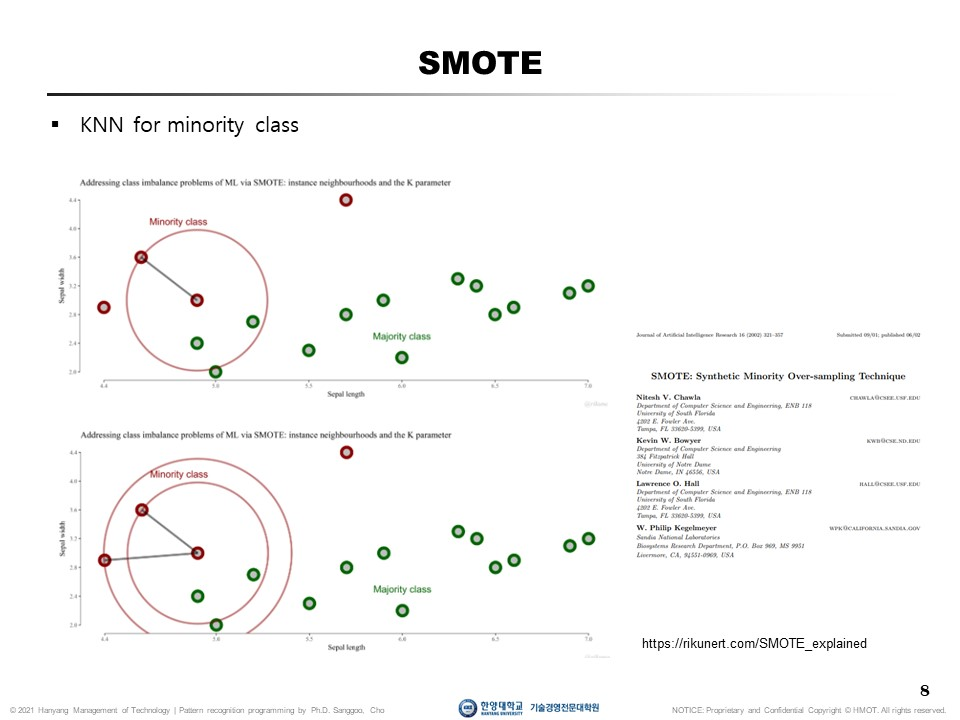

In [43]:
Image(filename='../image/imbalance/슬라이드8.jpg', width=width, height=height)

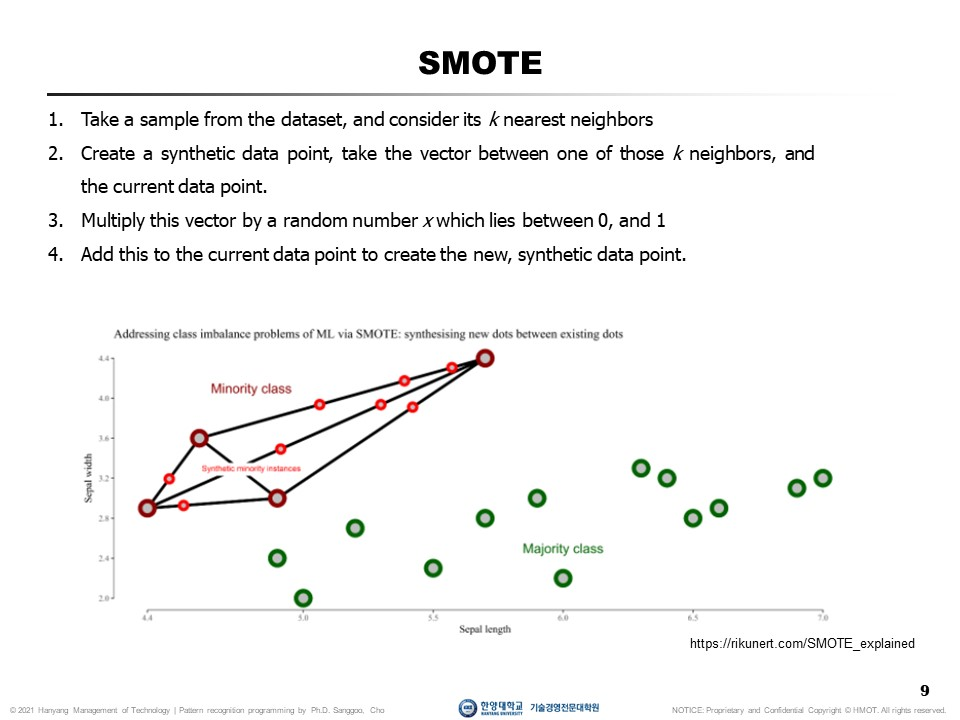

In [44]:
Image(filename='../image/imbalance/슬라이드9.jpg', width=width, height=height)

In [51]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [52]:
from collections import Counter
#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))

normal data distribution: Counter({0: 28430, 1: 51})


In [53]:
X_smote, y_smote = SMOTE().fit_resample(X,y) # SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

SMOTE data distribution: Counter({0: 28430, 1: 28430})


In [54]:
smote_pipeline = make_pipeline(SMOTE(random_state=4),
                               lgr)

In [55]:
smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

In [56]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: ")

print(classification_report(y_test, smote_prediction))
print(confusion_matrix(y_test, smote_prediction))

Confusion Matrix: 
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      5687
           1       0.02      0.80      0.04        10

    accuracy                           0.94      5697
   macro avg       0.51      0.87      0.51      5697
weighted avg       1.00      0.94      0.97      5697

[[5333  354]
 [   2    8]]


### 소수 범주 자료를 다수 범주 자료의 60%까지 오버샘플링(sampling_strategy = 0.6)


In [57]:
kf = KFold(n_splits=2)
imba_pipeline = make_pipeline(SMOTE(sampling_strategy = 0.6, random_state=42),
                              RandomForestClassifier(random_state=13))
cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)

array([0.78577293, 0.72909632])

In [58]:
for i in [0.3, 0.4, 0.5, 0.6, 0.7]:
    imba_pipeline = make_pipeline(SMOTE(sampling_strategy = i, random_state=42),
                                  RandomForestClassifier(random_state=13))
    print(f'sampling_strategy = {i}')
    cross_val_score(imba_pipeline, X_train, y_train, scoring='recall_macro', cv=kf)
    print('*'*100)

sampling_strategy = 0.3


array([0.78700446, 0.73120621])

****************************************************************************************************
sampling_strategy = 0.4


array([0.78656463, 0.73037104])

****************************************************************************************************
sampling_strategy = 0.5


array([0.78625674, 0.7297117 ])

****************************************************************************************************
sampling_strategy = 0.6


array([0.78577293, 0.72909632])

****************************************************************************************************
sampling_strategy = 0.7


array([0.78484928, 0.72839302])

****************************************************************************************************


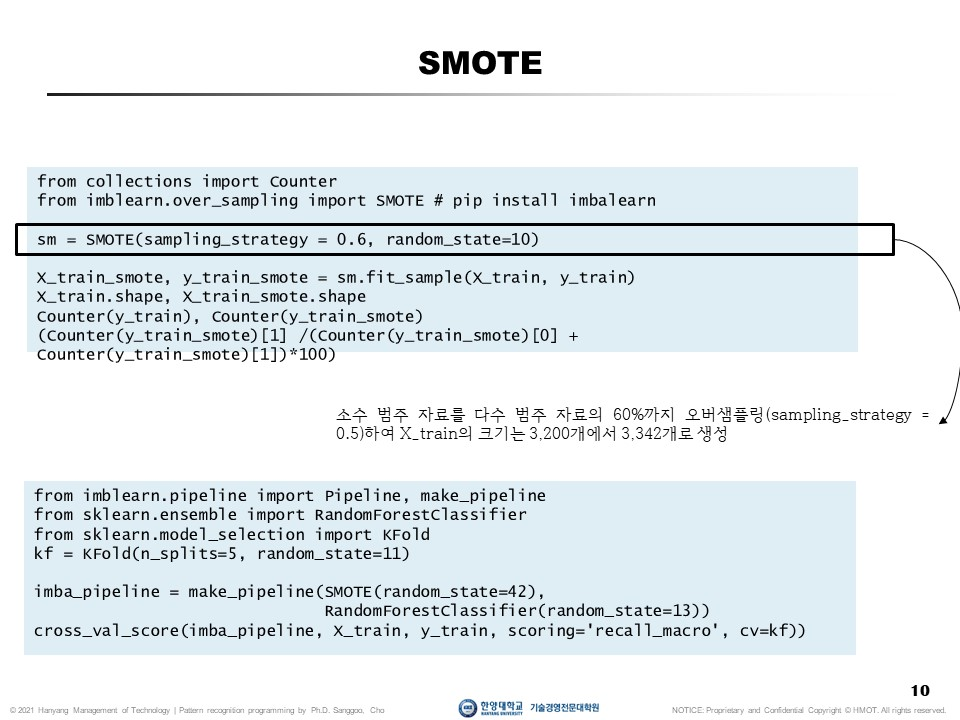

In [50]:
Image(filename='../image/imbalance/슬라이드10.jpg', width=width, height=height)

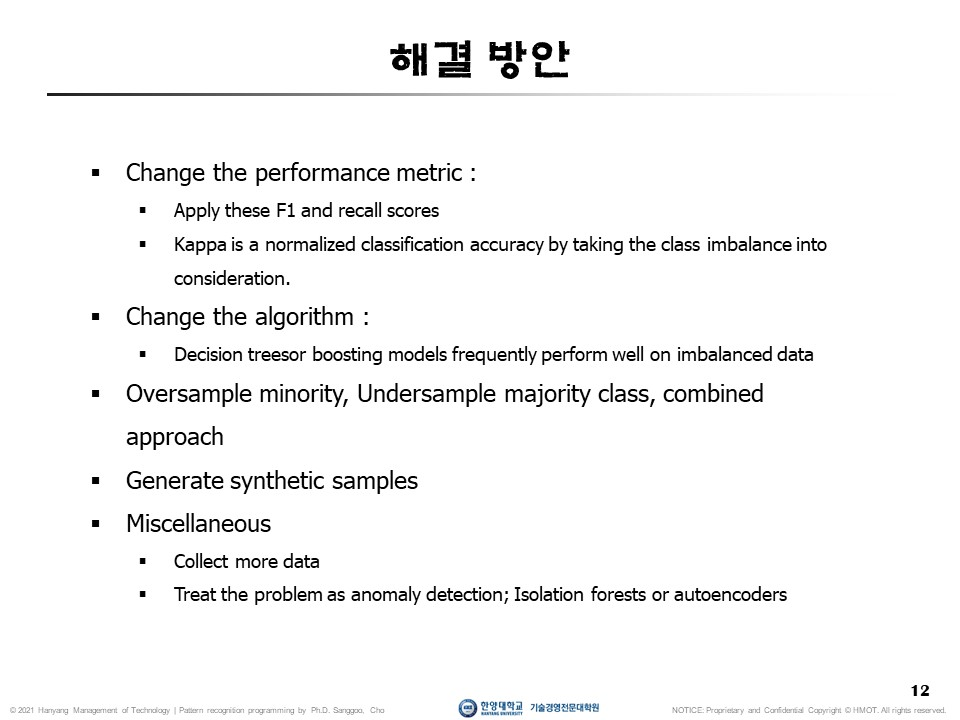

In [48]:
Image(filename='../image/imbalance/슬라이드12.jpg', width=width, height=height)

# Chapter 21 __ Imbalanced_classification_with_python(Jason brown)
## Probability Threshold Moving
## 1.  Optimal Threshold for ROC Curve

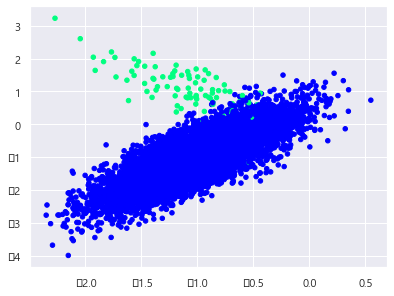

In [99]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=4)

plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='winter')

In [106]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]

# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)

LogisticRegression()

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

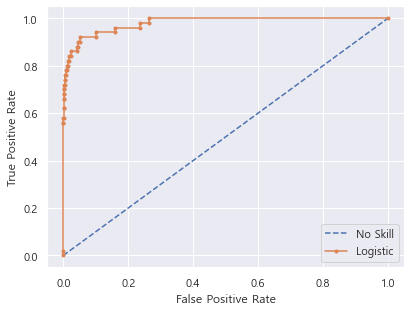

In [107]:
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

The Geometric Mean or G-mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and
the specificity. One approach would be to test the model with each threshold returned from the call roc auc score() and select the threshold with the largest G-mean value.

In [113]:
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.016153, G-mean=0.933


Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

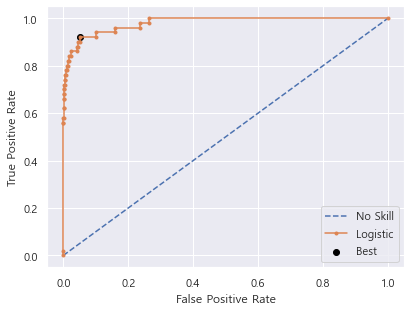

In [117]:
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

It turns out there is a much faster way to get the same result, called the Youden’s J statistic. The statistic is calculated as:
### J = Sensitivity + Specificity − 1 = Sensitivity + (1 − FalsePositiveRate) − 1 =  TruePositiveRate − FalsePositiveRate

In [119]:
# calculate roc curves
fpr, tpr, thresholds = roc_curve(testy, yhat)
# get the best threshold
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.016153


## 2. Optimal Threshold for Precision-Recall Curve
### Unlike the ROC Curve, a precision-recall curve focuses on the performance of a classifier on the positive (minority class) only.

Best Threshold=0.256036, F-measure=0.756


Text(0.5, 0, 'Recall')

Text(0, 0.5, 'Precision')

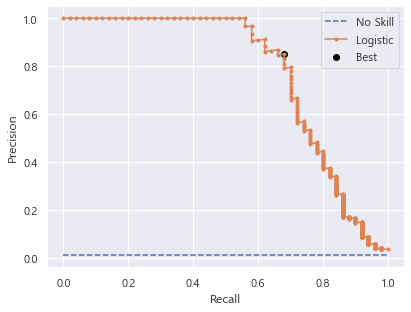

In [123]:
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(testy, yhat)

# convert to f-measure
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f-measure
ix = np.argmax(fscore)
print('Best Threshold=%f, F-measure=%.3f' % (thresholds[ix], fscore[ix]))

# plot the roc curve for the model
no_skill = len(testy[testy==1]) / len(testy)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

## 3. Optimal Threshold Tuning
Sometimes, we simply have a model and we wish to know the best threshold directly. In this case, we can define a set of thresholds and then evaluate predicted probabilities under each in order to find and select the optimal threshold.

In [126]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

In [128]:
# fit a model
model = LogisticRegression(solver='lbfgs')
model.fit(trainX, trainy)
# predict probabilities
yhat = model.predict_proba(testX)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)

# evaluate each threshold
from sklearn.metrics import f1_score
scores = [f1_score(testy, to_labels(probs, t)) for t in thresholds]

# get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F-measure=%.5f' % (thresholds[ix], scores[ix]))

LogisticRegression()

Threshold=0.251, F-measure=0.75556


## 다양한 metrics로 Tuning

In [141]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2)
from sklearn.model_selection import RandomizedSearchCV

In [142]:
# split into train/test sets
trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.5, random_state=2, stratify=y)
# fit a model
model = LogisticRegression(solver='lbfgs')

In [154]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'accuracy')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [155]:
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'recall')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [157]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'precision')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4950
           1       1.00      0.22      0.36        50

    accuracy                           0.99      5000
   macro avg       1.00      0.61      0.68      5000
weighted avg       0.99      0.99      0.99      5000



In [158]:
params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = 'f1')
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



In [168]:
from sklearn.metrics import fbeta_score, make_scorer
ftwo_scorer = make_scorer(fbeta_score, beta=3)

params = {'C': np.logspace(-4, 4, 20), 'penalty': ['l1', 'l2']}
grid = RandomizedSearchCV(model, param_distributions=params, cv=5, scoring = ftwo_scorer)
y_predict = grid.fit(trainX, trainy).predict(testX)
print(classification_report(testy, y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4950
           1       0.92      0.66      0.77        50

    accuracy                           1.00      5000
   macro avg       0.96      0.83      0.88      5000
weighted avg       1.00      1.00      1.00      5000



# END